In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import seaborn as sns; 
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score

In [3]:
#config parser
import configparser

sys.path.insert(0, '../Common/')
from AISDataManager import AISDataManager
import Constants as c
import HMUtils as hMUtil
import TimeUtils as timeUtils

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing
aISDM = AISDataManager()

In [4]:
lonMin = (float)(config['REGEION']['LON_MIN'])
lonMax = (float)(config['REGEION']['LON_MAX'])

latMin = (float)(config['REGEION']['LAT_MIN'])
latMax = (float)(config['REGEION']['LAT_MAX'])

print(lonMin,latMin)
print(lonMax,latMax)

increStep = (float)(config['HEATMAP']['INCR_STEP'])
incrRes = (int)(config['HEATMAP']['INCR_RES'])

-120.0 31.0
-117.0 34.5


In [5]:
xGrid = np.arange(lonMin,lonMax,increStep)
xGrid = np.around(xGrid,incrRes)
yGrid = np.arange(latMin,latMax,increStep)
yGrid = np.around(yGrid,incrRes)

In [6]:
heatMapDirectory = "../Data/AIS_0117_1217_31_M120_345_M117/HourlyHM/"

heatMapData = []
for i in range(0,8760):
    heatMapFile = heatMapDirectory + str(i) + '.npy'
    heatMapVal = np.load(heatMapFile)
    heatMapData.append(heatMapVal)

In [7]:
#find out the cells on which we want to train our model
#cells with zero entires are not useful to us
#go through every heat map

hMBoolSum = np.zeros((heatMapData[0].shape))
# #iterate through heat maps 
for hM in heatMapData:
    #find instances of heat map
    hMBool = hM > 0
    hMBoolSum = hMBoolSum + hMBool
print(hMBoolSum)

[37. 51. 43. ...  0.  0.  0.]


In [8]:
nonZeroGrid = np.argwhere(hMBoolSum > 100)

nonZeroGrid = nonZeroGrid.flatten()
nonZeroGrid = nonZeroGrid.tolist()

In [9]:
# print(nonZeroGrid)
print(len(nonZeroGrid))

814


In [10]:
def generate_region_data(index, bW):
    #histogram data
    histData = []
    histLabel = []

    #get the row and column of the desired grid
    indexRow, indexCol = hMUtil.get_row_col(index, yGrid.shape[0], xGrid.shape[0])
    
    width = xGrid.shape[0]
    height = yGrid.shape[0]
    
    #now iterate through heatmap files
    for hM in heatMapData:
        #copy the data file
        tempNP = hM.copy()
        
        #reshape it in 2D fashion
        #so that we can levarege the window
        tempNP = np.reshape(tempNP,(yGrid.shape[0],xGrid.shape[0]))
        
        #now slice the array 
        #here it has to be window
        #the regeion we are interested
        #and some cells which are near to this regeion
        leftRow = indexRow-bW
        if(leftRow < 0):
            leftRow = 0
            
        rightRow = indexRow+bW+1
        if(rightRow > height): 
            rightRow = height
            
        leftCol = (indexCol-bW)
        if(leftCol < 0):
            leftCol = 0
            
        rightCol = (indexCol+bW+1)
        if(rightCol > width): 
            rightCol = width
        
            
        histNPX = tempNP[(leftRow):(rightRow),leftCol:rightCol].copy()

        #now append this into the list
        histData.append(histNPX.flatten())

        #after that we have our own regeion
        histNPY = tempNP[indexRow,indexCol].copy()
        
        #we need to add things up for label
        histY = np.sum(histNPY)
        #append that into label
        histLabel.append(histY)
        
    histLabelNP = np.asarray(histLabel)
    return np.asarray(histData),histLabelNP

In [11]:
#will make a data set for time series forcast
#will consider how many previous data we want to consider
#will also take the feature matrix 
#and output feature
#will return matrix of reduced dimension
#which can be used as a feature factor
def make_time_series_data(matX,matY,pastFeatures,futureFeature = 0):
    #first make data set for time series regression
    #so based on past features to consider
    #we will have data set limited by that number
    noRowsX = matX.shape[0] - pastFeatures - futureFeature

    #initialise m*n dimensional array for X(where n is number of past features)
    #where m is total number data points for the training and testing
    #m will be noRowsX
    retXMat = np.zeros(shape=(noRowsX,(pastFeatures*matX.shape[1])))
        
    #initialise noRowsX*column dimensional array for Y
    retYMat = np.zeros(shape=(noRowsX))
    
                       
    for i in range(0,noRowsX):
        #numpy array with zero element
        temp = np.zeros(0)
        
        for j in range(i,i+pastFeatures):
            temp = np.append(temp,matX[j])
        retXMat[i] = temp
        retYMat[i] = matY[i+pastFeatures+futureFeature]
    return retXMat,retYMat,noRowsX

In [17]:
def make_svr_model(gridIndex):
    #generate regeion specific data
    dataX, dataY = generate_region_data(gridIndex,3)
    print(dataX.shape)
    print(dataY.shape)
    #convert that into time series
    dataXTS,dataYTS,noOfSamples = make_time_series_data(dataX,dataY,3)
    
    #add bias term
    biasTerm = np.ones(shape = (dataXTS.shape[0],1))
    print(biasTerm.shape)
    featureMat = np.hstack((biasTerm,dataXTS))
    print(featureMat.shape)
    
    #split into train and test
    dataXTrain,dataXTest,dataYTrain,dataYTest = train_test_split(featureMat\
                                                             ,dataYTS\
                                                             ,train_size = 0.8\
                                                             ,test_size = 0.2\
                                                             ,shuffle = False\
                                                            )
    
    #to normalise the data
    scaler = preprocessing.StandardScaler().fit(dataXTrain)
    dataXTrainNorm = scaler.transform(dataXTrain)
    
    #initalize svr model
    sVR = svm.SVR(kernel='rbf', epsilon=0.1 , gamma=0.001)
    
    #fit the model
    sVR.fit(dataXTrainNorm, dataYTrain.flatten())
    
    dataXTestNorm = scaler.transform(dataXTest)
    
    predTrain = sVR.predict(dataXTrainNorm)
    predTest = sVR.predict(dataXTestNorm)
    
    return predTrain, predTest

In [27]:
#lets compute
predTrainList = []
predTestList = []
# for i in range(1):
for i in range(xGrid.shape[0]*yGrid.shape[0]):
    ret1, ret2 = make_svr_model(i)
    predTrainList.append(ret1.copy())
    predTestList.append(ret2.copy())

0 0
(8760, 16)
(8760,)
(8757, 1)
(8757, 49)
0 1
(8760, 20)
(8760,)
(8757, 1)
(8757, 61)
0 2
(8760, 24)
(8760,)
(8757, 1)
(8757, 73)
0 3
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 4
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 5
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 6
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 7
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 8
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 9
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 10
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 11
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 12
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 13
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 14
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 15
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 16
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 17
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 18
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 19
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 20
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 21
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
0 22
(8760, 28)
(876

6 1
(8760, 35)
(8760,)
(8757, 1)
(8757, 106)
6 2
(8760, 42)
(8760,)
(8757, 1)
(8757, 127)
6 3
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 4
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 5
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 6
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 7
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 8
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 9
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 10
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 11
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 12
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 13
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 14
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 15
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 16
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 17
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 18
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 19
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 20
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 21
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
6 22
(8760, 49)
(8760,)
(8757, 1)
(8757, 14

12 0
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
12 1
(8760, 35)
(8760,)
(8757, 1)
(8757, 106)
12 2
(8760, 42)
(8760,)
(8757, 1)
(8757, 127)
12 3
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 4
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 5
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 6
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 7
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 8
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 9
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 10
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 11
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 12
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 13
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 14
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 15
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 16
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 17
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 18
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 19
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 20
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
12 21
(8760, 49)
(8760,)

17 26
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
17 27
(8760, 42)
(8760,)
(8757, 1)
(8757, 127)
17 28
(8760, 35)
(8760,)
(8757, 1)
(8757, 106)
17 29
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
18 0
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
18 1
(8760, 35)
(8760,)
(8757, 1)
(8757, 106)
18 2
(8760, 42)
(8760,)
(8757, 1)
(8757, 127)
18 3
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 4
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 5
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 6
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 7
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 8
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 9
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 10
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 11
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 12
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 13
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 14
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 15
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 16
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
18 17
(8760, 49)
(8760,)


23 22
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
23 23
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
23 24
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
23 25
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
23 26
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
23 27
(8760, 42)
(8760,)
(8757, 1)
(8757, 127)
23 28
(8760, 35)
(8760,)
(8757, 1)
(8757, 106)
23 29
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
24 0
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
24 1
(8760, 35)
(8760,)
(8757, 1)
(8757, 106)
24 2
(8760, 42)
(8760,)
(8757, 1)
(8757, 127)
24 3
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
24 4
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
24 5
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
24 6
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
24 7
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
24 8
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
24 9
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
24 10
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
24 11
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
24 12
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
24 13
(8760, 49)
(8760,)


29 18
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
29 19
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
29 20
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
29 21
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
29 22
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
29 23
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
29 24
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
29 25
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
29 26
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
29 27
(8760, 42)
(8760,)
(8757, 1)
(8757, 127)
29 28
(8760, 35)
(8760,)
(8757, 1)
(8757, 106)
29 29
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
30 0
(8760, 28)
(8760,)
(8757, 1)
(8757, 85)
30 1
(8760, 35)
(8760,)
(8757, 1)
(8757, 106)
30 2
(8760, 42)
(8760,)
(8757, 1)
(8757, 127)
30 3
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
30 4
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
30 5
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
30 6
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
30 7
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
30 8
(8760, 49)
(8760,)
(8757, 1)
(8757, 148)
30 9
(8760, 49)
(8760,)


In [33]:
print(len(predTrainList))
print(len(predTestList))

1050
1050


In [34]:
print(predTrainList[0].shape)

(7005,)


In [35]:
print(predTestList[0].shape)

(1752,)


In [31]:
predictedHM = []
for i in range(8757):
    #make heatmap of zero    
    hM = np.zeros(xGrid.shape[0]*yGrid.shape[0])
    predictedHM.append(hM.copy())

In [36]:
for gridIndex in range(xGrid.shape[0]*yGrid.shape[0]):
    predTrainList[gridIndex]
    #first make training heat maps
    for i in range(7005):
        predictedHM[i][gridIndex] = predTrainList[gridIndex][i]
    testCount = 0
    #then make testing heat maps
    for i in range(7005,8757):
        predictedHM[i][gridIndex] = predTestList[gridIndex][testCount]
        testCount = testCount + 1

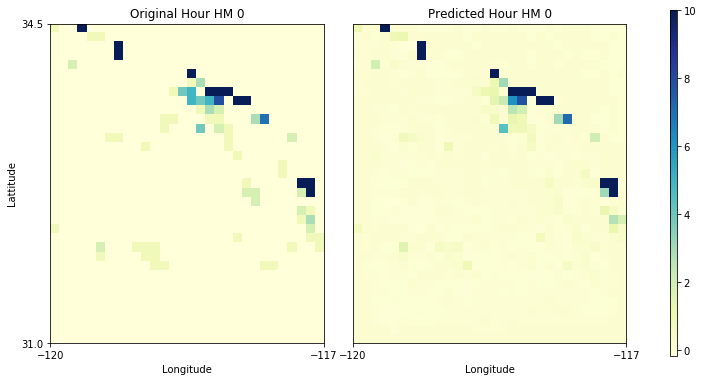

In [81]:
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 6

if useAspect == 1:
    figHeight = figWidth/aspectRatio

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.10, 0.11, 0.38, 0.80])
ax2 = fig.add_axes([0.52, 0.11, 0.38, 0.80])
ax3 = fig.add_axes([0.96, 0.11, 0.01, 0.80])
# hourCounter = 0

def animate(hourCounter):
    predictImg = np.reshape(predictedHM[hourCounter],(yGrid.shape[0],xGrid.shape[0]))
    predictImg = np.flip(predictImg,axis = 0)
    origImg = np.reshape(heatMapData[hourCounter + 3],(yGrid.shape[0],xGrid.shape[0]))
    origImg = np.flip(origImg,axis = 0)

    # ax1 = plt.subplot(1,2,1)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])
    ogHandler = ax1.imshow(origImg, cmap=plt.get_cmap('YlGnBu'), extent=[lonMin,lonMax,latMin,latMax], vmax = 10)
    titleStr = "Original Hour HM " + str(hourCounter)
    ax1.set_title(titleStr)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')

    # ax2 = plt.subplot(1,2,2)
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([])
    predHandler = ax2.imshow(predictImg, cmap=plt.get_cmap('YlGnBu'), extent=[lonMin,lonMax,latMin,latMax], vmax = 10)
    titleStr = "Predicted Hour HM " + str(hourCounter)
    ax2.set_title(titleStr)
    ax2.set_xlabel('Longitude')
    fig.colorbar(predHandler,ax3)
    
anim = animation.FuncAnimation(fig, animate,frames=200, interval=500)

In [82]:
HTML(anim.to_html5_video())

In [83]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

In [84]:
anim.save('HMPredictSVRTrain.mp4', writer=writer)

In [80]:
dirToStore = '../Data/AIS_0117_1217_31_M120_345_M117/PredictedHM/'
for i in range(8757):
    fileToStore = dirToStore + str(i) + '.npy'
    np.save(fileToStore, predictedHM[i])
    #make heatmap of zero    
#     hM = np.zeros(xGrid.shape[0]*yGrid.shape[0])
#     predictedHM.append(hM.copy())

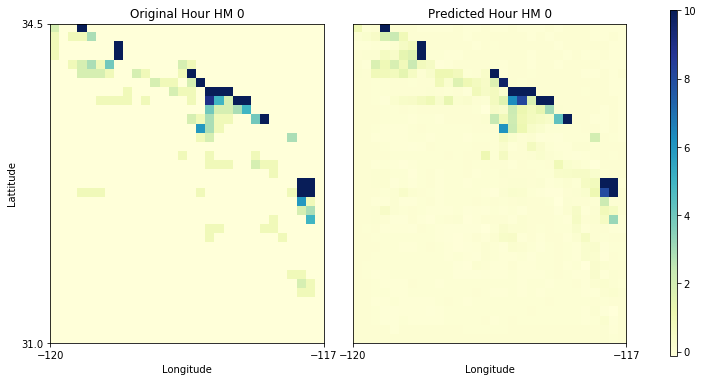

In [85]:
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 6

if useAspect == 1:
    figHeight = figWidth/aspectRatio

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.10, 0.11, 0.38, 0.80])
ax2 = fig.add_axes([0.52, 0.11, 0.38, 0.80])
ax3 = fig.add_axes([0.96, 0.11, 0.01, 0.80])
# hourCounter = 0

def animate(hourCounter):
    predictImg = np.reshape(predictedHM[hourCounter+7005],(yGrid.shape[0],xGrid.shape[0]))
    predictImg = np.flip(predictImg,axis = 0)
    origImg = np.reshape(heatMapData[hourCounter + 3+7005],(yGrid.shape[0],xGrid.shape[0]))
    origImg = np.flip(origImg,axis = 0)

    # ax1 = plt.subplot(1,2,1)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])
    ogHandler = ax1.imshow(origImg, cmap=plt.get_cmap('YlGnBu'), extent=[lonMin,lonMax,latMin,latMax], vmax = 10)
    titleStr = "Original Hour HM " + str(hourCounter)
    ax1.set_title(titleStr)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')

    # ax2 = plt.subplot(1,2,2)
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([])
    predHandler = ax2.imshow(predictImg, cmap=plt.get_cmap('YlGnBu'), extent=[lonMin,lonMax,latMin,latMax], vmax = 10)
    titleStr = "Predicted Hour HM " + str(hourCounter)
    ax2.set_title(titleStr)
    ax2.set_xlabel('Longitude')
    fig.colorbar(predHandler,ax3)
    
anim = animation.FuncAnimation(fig, animate,frames=200, interval=500)

In [86]:
HTML(anim.to_html5_video())

In [87]:
anim.save('HMPredictSVRTest.mp4', writer=writer)

In [ ]:
# # cS = [0.00001,0.00001,0.0001,0.001, 0.01, 0.1, 1, 10]
# # gammas = [0.00001,0.00001,0.0001,0.001, 0.01, 0.1, 1]
# # epsiolons = [0.00001,0.0001,0.001, 0.01, 0.1, 1]

# cS = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1]
# epsiolons = [0.001, 0.01, 0.1, 1]

# paramGrid = {'C': cS, 'gamma' : gammas, 'epsilon' : epsiolons}

# gridSearch = GridSearchCV(svm.SVR(kernel='rbf'), paramGrid, cv=5, verbose=1, n_jobs = -1)
# gridSearch.fit(dataXTrainNorm, dataYTrain)

In [ ]:
# cS = [0.00001,0.00001,0.0001,0.001, 0.01, 0.1, 1, 10]
# gammas = [0.00001,0.00001,0.0001,0.001, 0.01, 0.1, 1]

# paramGrid = {'C': cS, 'gamma' : gammas}

# gridSearch = GridSearchCV(svm.SVC(kernel='rbf'), paramGrid, n_jobs = -1)
# gridSearch.fit(dataXTrainNorm, dataYTrain)

In [ ]:
# sVR = gridSearch.best_estimator_
# sVR.fit(dataXTrainNorm, dataYTrain.flatten())

In [ ]:
# #lets see whats the score
# #we will return it to plot the matrix
# trainScore = sVR.score(dataXTrainNorm,dataYTrain)
# print(trainScore)

In [ ]:
# dataXTestNorm = scaler.transform(dataXTest)

In [ ]:
# testScore = sVR.score(dataXTestNorm,dataYTest)
# print(testScore)

In [ ]:
# predTrain = sVR.predict(dataXTrainNorm)
# predTest = sVR.predict(dataXTestNorm)

In [ ]:
# ax1 = plt.subplot(1,2,1)
# ax1.set_ylim(min(np.min(predTrain),np.min(dataYTrain)),max(np.max(predTrain),np.max(dataYTrain)))
# ax1.plot(predTrain)
# ax1.set_title("Prediction Train")

# ax1 = plt.subplot(1,2,2)
# ax1.set_ylim(min(np.min(predTrain),np.min(dataYTrain)),max(np.max(predTrain),np.max(dataYTrain)))
# ax1.plot(dataYTrain)
# ax1.set_title("Original Train")
# plt.savefig("TrainData")

In [ ]:
# ax1 = plt.subplot(1,2,1)
# ax1.set_ylim(min(np.min(predTest),np.min(dataYTest)),max(np.max(predTest),np.max(dataYTest)))
# ax1.plot(predTest)
# ax1.set_title("Prediction Test")

# ax1 = plt.subplot(1,2,2)
# ax1.set_ylim(min(np.min(predTest),np.min(dataYTest)),max(np.max(predTest),np.max(dataYTest)))
# ax1.plot(dataYTest)
# ax1.set_title("Original Test")
# plt.savefig("TestData")

In [ ]:
# fig, ax = plt.subplots()
# diff = abs(predTest - dataYTest)
# ax.set_title("Count Difference")
# ax.plot(diff)
# plt.savefig("CountDiff.png")